In [ ]:
# importing the necessary libraries
import pandas  as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score    

In [ ]:
# Reading the dataset
df = pd.read_csv("EV.csv")

In [ ]:
# Checking the data types, non-null values, and memory usage
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20819 entries, 0 to 20818
Data columns (total 10 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   Date                                      20819 non-null  object 
 1   County                                    20733 non-null  object 
 2   State                                     20733 non-null  object 
 3   Vehicle Primary Use                       20819 non-null  object 
 4   Battery Electric Vehicles (BEVs)          20819 non-null  object 
 5   Plug-In Hybrid Electric Vehicles (PHEVs)  20819 non-null  object 
 6   Electric Vehicle (EV) Total               20819 non-null  object 
 7   Non-Electric Vehicle Total                20819 non-null  object 
 8   Total Vehicles                            20819 non-null  object 
 9   Percent Electric Vehicles                 20819 non-null  float64
dtypes: float64(1), object(9)
memory us

In [ ]:
# Checking for null values
df.isnull().sum()

Date                                         0
County                                      86
State                                       86
Vehicle Primary Use                          0
Battery Electric Vehicles (BEVs)             0
Plug-In Hybrid Electric Vehicles (PHEVs)     0
Electric Vehicle (EV) Total                  0
Non-Electric Vehicle Total                   0
Total Vehicles                               0
Percent Electric Vehicles                    0
dtype: int64

In [ ]:
# Displaying the number of rows and columns in the dataset
print(f'number of rows : {df.shape[0]}  \nnumber of columns : {df.shape[1]}')

number of rows : 20819  
number of columns : 10


In [ ]:
# Checking for missing values
missing_percentage = (df.isnull().sum() / len(df)) * 100
print("\nPercentage of missing values:")
print(missing_percentage)


Percentage of missing values:
Date                                        0.000000
County                                      0.413084
State                                       0.413084
Vehicle Primary Use                         0.000000
Battery Electric Vehicles (BEVs)            0.000000
Plug-In Hybrid Electric Vehicles (PHEVs)    0.000000
Electric Vehicle (EV) Total                 0.000000
Non-Electric Vehicle Total                  0.000000
Total Vehicles                              0.000000
Percent Electric Vehicles                   0.000000
dtype: float64


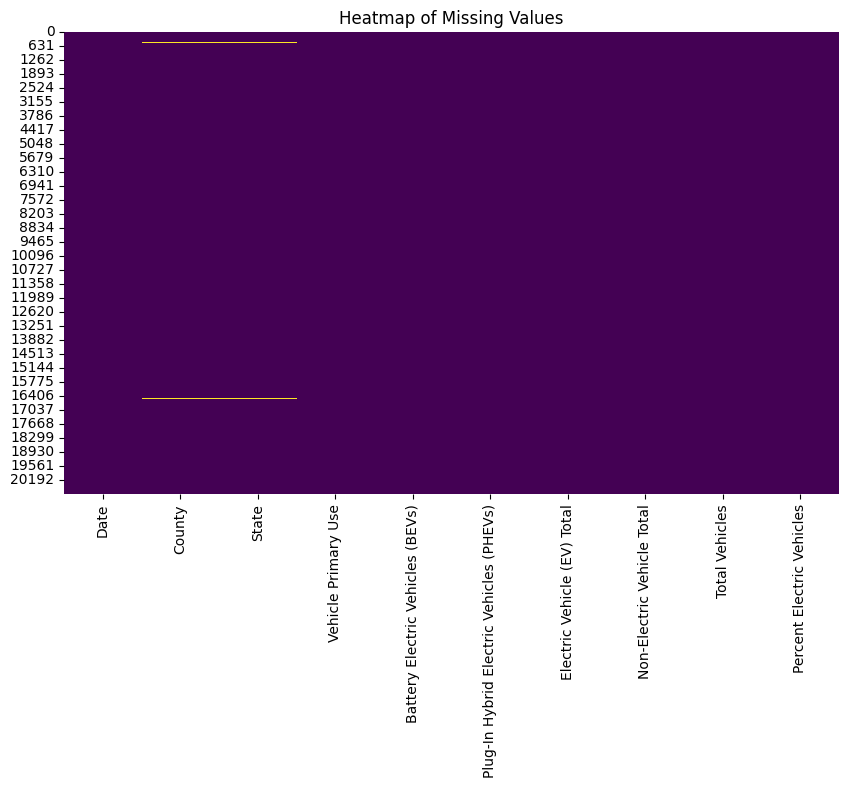

In [ ]:
# Visualizing the missing values using a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title("Heatmap of Missing Values")
plt.show()

Here, we can see that there are missing values in the dataset, particularly in the 'Country' and 'State' columns. The heatmap visually represents the missing values, where yellow indicates missing data and purple indicates present data.
So our main focus will be on fixing these missing values first.


In [ ]:
# Displaying the first 5 rows of the dataset
df.head()

,Date,County,State,Vehicle Primary Use,Battery Electric Vehicles (BEVs),Plug-In Hybrid Electric Vehicles (PHEVs),Electric Vehicle (EV) Total,Non-Electric Vehicle Total,Total Vehicles,Percent Electric Vehicles
0,September 30 2022,Riverside,CA,Passenger,7,0,7,460,467,1.50
1,December 31 2022,Prince William,VA,Passenger,1,2,3,188,191,1.57
2,January 31 2020,Dakota,MN,Passenger,0,1,1,32,33,3.03
3,June 30 2022,Ferry,WA,Truck,0,0,0,"3,575","3,575",0.00
4,July 31 2021,Douglas,CO,Passenger,0,1,1,83,84,1.19


In [ ]:
# Checking for outliers in the 'Percent Electric Vehicles' column
percent_ev = pd.to_numeric(df['Percent Electric Vehicles'], errors='coerce').dropna()

Q1 = percent_ev.quantile(0.25)
Q3 = percent_ev.quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = percent_ev[(percent_ev < lower_bound) | (percent_ev > upper_bound)]
print(f"Number of outliers: {len(outliers)}")


Number of outliers: 2476


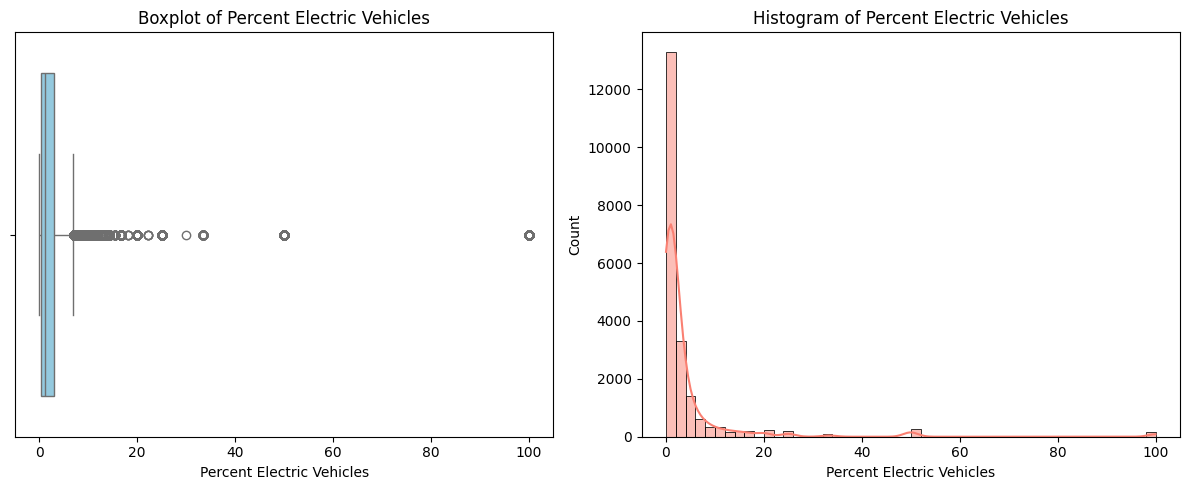

In [ ]:
# Visualizing the distribution of 'Percent Electric Vehicles' with boxplot and histogram
plt.figure(figsize=(12, 5))

# Boxplot
plt.subplot(1, 2, 1)
sns.boxplot(x=percent_ev, color='skyblue')
plt.title('Boxplot of Percent Electric Vehicles')

# Histogram
plt.subplot(1, 2, 2)
sns.histplot(percent_ev, bins=50, kde=True, color='salmon')
plt.title('Histogram of Percent Electric Vehicles')

plt.tight_layout()
plt.show()

### What We Can Conclude from the Visualization

**Boxplot Observations:**
- Most values are clustered between 0% and approximately 7–8%.
- There are many outliers beyond that range, even reaching close to 100%.
- The extreme right-side values (e.g., 40%, 60%, 99%) are clearly outliers based on the IQR rule.

**Histogram Observations:**
- The distribution is heavily right-skewed.
- Most values fall within the 0% to 5% range and taper off quickly.
- A few regions have very high EV penetration, which contributes to the outliers in the tail of the distribution.

**Conclusion:**
Removing these outliers is not a suitable option, as they may represent valid, high-adoption regions. Instead, we will use **winsorization** to cap all values beyond the IQR upper bound. This approach helps reduce the impact of extreme values without removing important data points, ensuring more stable model performance.

In [19]:
# Cap extreme values to limit the influence of outliers without removing data
df['Percent Electric Vehicles'] = np.where(df['Percent Electric Vehicles'] > upper_bound, upper_bound,
                                 np.where(df['Percent Electric Vehicles'] < lower_bound, lower_bound, df['Percent Electric Vehicles']))

# Locate the capped outliers
outliers = df[(df['Percent Electric Vehicles'] < lower_bound) | (df['Percent Electric Vehicles'] > upper_bound)]
print("Total outliers detected in 'Percent Electric Vehicles':", outliers.shape[0])

Total outliers detected in 'Percent Electric Vehicles': 0


### Handling Missing Values in County and State Columns

In this step, we are dropping the rows where the `County` or `State` values are missing, instead of filling them with a placeholder like `'Unknown'`.

Replacing missing values with `'Unknown'` would create a new, artificial category that does not represent any actual location. This can negatively affect the model's performance, especially when predicting based on geographic regions.

Since our analysis and predictions are region-specific, keeping such placeholder values would introduce noise and reduce the interpretability of the results. Dropping these rows helps ensure that we only work with complete and meaningful regional data.

Also, the number of rows with missing values is very small compared to the overall dataset, so removing them does not significantly impact the dataset size or quality.


In [21]:
# Convert Date column to datetime
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# Drop rows with invalid Date
df = df[df['Date'].notnull()]

# Drop rows with missing EV Total
df = df[df['Electric Vehicle (EV) Total'].notnull()]

# Drop rows where County or State is missing
df = df.dropna(subset=['County', 'State'])

# Confirm remaining nulls
print("Missing values after cleaning:")
print(df[['County', 'State']].isnull().sum())

Missing values after cleaning:
County    0
State     0
dtype: int64
